In [1]:
from __future__ import annotations
import matplotlib.pyplot as plt
from typing import Optional
from munkres import Munkres
from tqdm import tqdm
import numpy as np
import random
import torch.nn.functional as F
import torch.nn as nn
import torch

In [2]:
def get_untried_actions(state: np.ndarray, depth: int) -> list[int]:
    """Return a list of untried actions."""
    if depth >= state[1].shape[0]:
        return []
    return np.argwhere(state[1][depth] == 1).flatten().tolist()


class Node:

    def __init__(self, state: np.ndarray, config: dict, parent=None, action=None, depth=0):
        self.state = state
        self.config = config
        self.parent = parent
        self.action = action
        self.depth = depth

        self.children: list[Node] = []

        self.visit_count = 0
        self.value = 0

    def is_expanded(self) -> bool:
        """Returns True if the node has children."""
        return len(self.children) > 0

    def select(self) -> Optional[Node]:
        """Return the child with the highest UCB score."""
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child: Node) -> float:
        """Return the UCB score of a child node."""
        if child.visit_count == 0:
            return np.inf
        exploitation = child.value / child.visit_count
        exploration = self.config["exploration_constant"] * np.sqrt(np.log(self.visit_count) / child.visit_count)

        return exploitation + exploration

    def expand(self) -> None:
        """Expand the node by creating all possible children."""
        child = None
        for action in get_untried_actions(self.state, self.depth):
            new_state = self.state.copy()
            new_state[1][self.depth] = 0
            new_state[1][:, action] = 0
            new_state[2][self.depth][action] = 1

            child = Node(new_state, self.config, self, action, self.depth + 1)
            self.children.append(child)

    def backpropagate(self, value: float) -> None:
        """Update the node's value and visit count."""
        self.value += value
        self.visit_count += 1

        if self.parent is not None:
            self.parent.backpropagate(value)


class MCTS:

    def __init__(self, root: Node, config: dict, max_depth: int, max_iterations: int = 1000):
        self.root = root
        self.config = config
        self.max_depth = max_depth
        self.max_iterations = max_iterations

    def search(self) -> int:
        for _ in range(self.max_iterations):
            node = self.select_node()
            value = self.rollout(node)
            node.backpropagate(value)

        best_action = None
        best_value = -np.inf
        for child in self.root.children:
            if child.visit_count > best_value:
                best_action = child.action
                best_value = child.visit_count
        if best_action is None:
            raise ValueError("No best action found.")
        return int(best_action)

    def select_node(self) -> Node:
        """Select a node to expand."""
        node = self.root
        while node.is_expanded():
            node = node.select()
            if node is None:
                raise ValueError("Selecting a childless node.")
        if not node.is_expanded():
            node.expand()
        return node

    def rollout(self, node: Node) -> float:
        """Simulate a game from the given node."""
        state = node.state.copy()
        depth = node.depth
        while depth < self.max_depth:
            actions = get_untried_actions(state, depth)
            if len(actions) == 1:
                action = actions[0]
            elif self.config["rollout_mode"] == "random":
                action = random.choice(actions)
            else:
                actions_values = [state[0][depth][action] for action in actions]
                total_value = sum(actions_values)
                action_probs = [abs((value - total_value) ** 2) for value in actions_values]
                normalized_probs = [prob / sum(action_probs) for prob in action_probs]
                action = random.choices(actions, normalized_probs)[0]

            state[1][depth] = 0
            state[1][:, action] = 0
            state[2][depth][action] = 1
            depth += 1
        return self.evaluate(state)

    def evaluate(self, state: np.ndarray) -> float:
        """Evaluate the given state."""
        return 1 - np.multiply(state[0], state[2]).sum() / state[0].sum()

In [3]:
config = {
    "exploration_constant": 2,
    "rollout_mode": "random"
}

In [4]:
def get_mcts_cost(matrix: np.ndarray, config:dict, max_depth: int, max_iterations: int) -> tuple[list[int], float]:
    state = np.stack([matrix, np.ones(matrix.shape), np.zeros(matrix.shape)], axis=0)
    actions = []
    for i in range(matrix.shape[0]):
        root = Node(state, config, depth=i)
        mcts = MCTS(root, config, max_depth, max_iterations)
        action = mcts.search()
        actions.append(action)
        state[1][i] = 0
        state[1][:, action] = 0
        state[2][i][action] = 1

    return actions, sum(matrix[i][action] for i, action in enumerate(actions))

size = 3
random_matrix = np.random.randint(1, 20, (size, size))
mcts_actions, mcts_cost = get_mcts_cost(random_matrix, config, size, 100)
print(f"Random matrix:\n{random_matrix}")
print(f"MCST actions: {mcts_actions}")
print(f"MCTS cost: {mcts_cost}")

# Hungarian algorithm
m = Munkres()
indexes = m.compute(random_matrix.copy().tolist())
cost = 0
for row, column in indexes:
    value = random_matrix[row][column]
    cost += value
print(f"Hungarian actions: {[column for row, column in indexes]}")
print(f"Hungarian cost: {cost}")

Random matrix:
[[17 16 13]
 [16  8 13]
 [12  2  6]]
MCST actions: [0, 1, 2]
MCTS cost: 31
Hungarian actions: [0, 1, 2]
Hungarian cost: 31


In [5]:
# Benchmark
size = 10
max_iterations = 1000

mstc_scores = []
hungarian_scores = []

config = {
    "exploration_constant": 0.1,
    "rollout_mode": "random"
}

for _ in tqdm(range(100)):
    random_matrix = np.random.randint(1, 100, (size, size))

    _, mcts_cost = get_mcts_cost(random_matrix, config, size, max_iterations)
    mstc_scores.append(mcts_cost)

    m = Munkres()
    indexes = m.compute(random_matrix.copy().tolist())
    cost = 0
    for row, column in indexes:
        value = random_matrix[row][column]
        cost += value
    hungarian_scores.append(cost)

print(f"MCTS average score: {np.mean(mstc_scores)}")
print(f"Hungarian average score: {np.mean(hungarian_scores)}")

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

MCTS average score: 165.31
Hungarian average score: 139.78


100%|██████████| 10/10 [01:00<00:00,  6.09s/it]


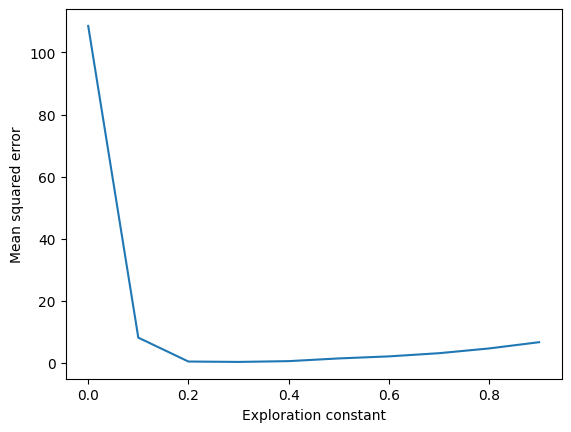

In [6]:
size = 3
max_iterations = 100

errors = []
for c in tqdm(np.arange(0, 1, 0.1)):
    config = {
        "exploration_constant": c,
        "rollout_mode": "other"
    }
    mstc_scores = []
    munkres_scores = []
    for _ in range(1000):
        random_matrix = np.random.randint(1, 100, (size, size))
        _, mcts_cost = get_mcts_cost(random_matrix, config, size, max_iterations)
        mstc_scores.append(mcts_cost)

        m = Munkres()
        indexes = m.compute(random_matrix.copy().tolist())
        cost = 0
        for row, column in indexes:
            value = random_matrix[row][column]
            cost += value
        munkres_scores.append(cost)

    errors.append(np.mean((np.array(mstc_scores) - np.array(munkres_scores)) ** 2))

plt.plot(np.arange(0, 1, 0.1), errors)
plt.xlabel("Exploration constant")
plt.ylabel("Mean squared error")
plt.show()

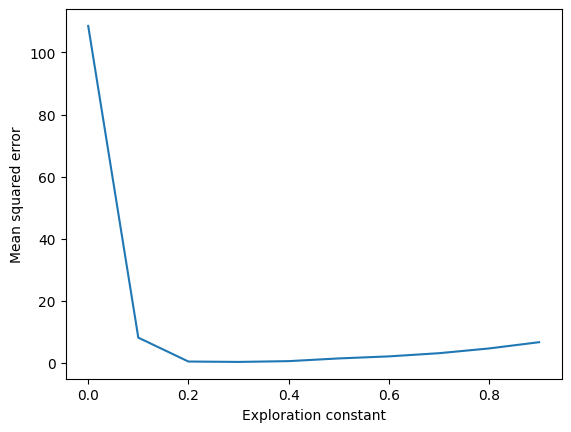

In [7]:
plt.plot(np.arange(0, 1, 0.1), errors)
plt.xlabel("Exploration constant")
plt.ylabel("Mean squared error")
plt.show()

In [34]:
class ResNet(nn.Module):

    def __init__(self, state_size: int, input_size: int, num_resBlocks: int, num_hidden: int) -> None:
        super().__init__()
        self.startBlock = nn.Sequential(
            nn.Conv2d(input_size, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for _ in range(num_resBlocks)]
        )

        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * state_size, 1),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        return self.valueHead(x)


class ResBlock(nn.Module):

    def __init__(self, num_hidden: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden,
                               kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden,
                               kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the residual block."""
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x
    

class CNNModel(nn.Module):

    def __init__(self, state_size: int, input_size: int, num_hidden: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(input_size, num_hidden, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.fc = nn.Linear(num_hidden * state_size, 2)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through thenetwork."""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [98]:
%load_ext tensorboard

def generate_datas(n: int, size: int) -> tuple[np.ndarray, np.ndarray]:
    states = []
    values = []

    for _ in range(n):
        # Create a random matrix and a random permutation
        random_matrix = np.random.randint(1, 100, (size, size)).astype(np.float32)
        # Normalize the matrix line by line
        for i in range(size):
            total_value = random_matrix[i].sum()
            probs = [abs((value - total_value) ** 2) for value in random_matrix[i]]
            normalized_probs = [prob / sum(probs) for prob in probs]
            random_matrix[i] = np.round(normalized_probs, 2)

        random_permutation = np.random.permutation(size)
        solution = np.zeros((size, size))

        # Solve the problem with the Hungarian algorithm
        m = Munkres()
        indexes = m.compute(random_matrix.copy().tolist())
        valide_solution = np.zeros((size, size))
        for row, column in indexes:
            valide_solution[row][column] = 1


        state = np.stack([random_matrix, valide_solution], axis=0)
        state = torch.tensor(state, dtype=torch.float32)
        states.append(state)
        values.append(1)

        is_valid = True
        for k in range(np.random.randint(1, size + 1)):
            solution[k][random_permutation[k]] = 1
            if valide_solution[k][random_permutation[k]] != 1:
                is_valid = False

        state = np.stack([random_matrix, solution], axis=0)
        states.append(state)
        values.append(1 if is_valid else 0)

    return np.stack(states, axis=0), np.array(values)

size = 10
train_states, train_values = generate_datas(10000, size)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [101]:
size = 10

model = CNNModel(
    state_size=size**2,
    input_size=2,
    num_hidden=64
)

# Create a dataset and a dataloader
dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_states, dtype=torch.float32),
    torch.tensor(train_values, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Create a loss function and an optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    running_loss = 0
    for states, values in dataloader:
        optimizer.zero_grad()
        outputs = model(states)
        values = values.unsqueeze(1)
        values = torch.cat([1 - values, values], dim=1)

        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, loss: {running_loss / len(dataloader) * 10:.2f}")

# Test the model
size = 10
test_states, test_values = generate_datas(100, size)
outputs = model(torch.tensor(test_states, dtype=torch.float32))
values = test_values
values = values.reshape(-1, 1)
values = np.concatenate([1 - values, values], axis=1)
loss = criterion(outputs, torch.tensor(values, dtype=torch.float32))
print(f"Test loss: {loss.item() * 10:.2f}")

Epoch 1, loss: 6.96%
Epoch 2, loss: 5.10%
Epoch 3, loss: 5.08%
Epoch 4, loss: 4.94%
Epoch 5, loss: 4.47%
Epoch 6, loss: 3.02%
Epoch 7, loss: 2.05%
Epoch 8, loss: 1.71%
Epoch 9, loss: 1.51%
Epoch 10, loss: 1.38%
Test loss: 0.021882377564907074


In [104]:
test_states, test_values = generate_datas(1, size)
print(test_states, test_values)
outputs = model(torch.tensor(test_states, dtype=torch.float32))
print(outputs)

[[[[0.1  0.09 0.08 0.09 0.08 0.12 0.08 0.12 0.11 0.12]
   [0.08 0.1  0.09 0.09 0.09 0.12 0.11 0.09 0.11 0.11]
   [0.08 0.11 0.11 0.07 0.12 0.11 0.12 0.07 0.11 0.11]
   [0.11 0.1  0.12 0.11 0.11 0.09 0.09 0.09 0.11 0.08]
   [0.09 0.1  0.09 0.11 0.08 0.1  0.1  0.1  0.11 0.11]
   [0.06 0.08 0.12 0.09 0.12 0.11 0.11 0.08 0.12 0.12]
   [0.12 0.1  0.11 0.07 0.11 0.1  0.09 0.09 0.11 0.1 ]
   [0.11 0.12 0.11 0.08 0.09 0.09 0.09 0.09 0.12 0.1 ]
   [0.12 0.09 0.11 0.09 0.12 0.09 0.09 0.09 0.08 0.12]
   [0.1  0.12 0.1  0.09 0.08 0.1  0.12 0.09 0.09 0.1 ]]

  [[0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
   [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
   [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
   [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
   [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
   [0.  

[[[0.47999999 0.22       0.30000001]
  [0.25999999 0.57999998 0.16      ]
  [0.25999999 0.38999999 0.34999999]]

 [[0.         1.         0.        ]
  [0.         0.         1.        ]
  [1.         0.         0.        ]]] 1


c:\Users\hugoh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\hugoh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, loss: 0.9593924283981323
Epoch 3, loss: 0.8589998483657837
Epoch 10, loss: 0.7182757258415222
Epoch 11, loss: 0.6619675159454346
Epoch 50, loss: 0.6013190746307373


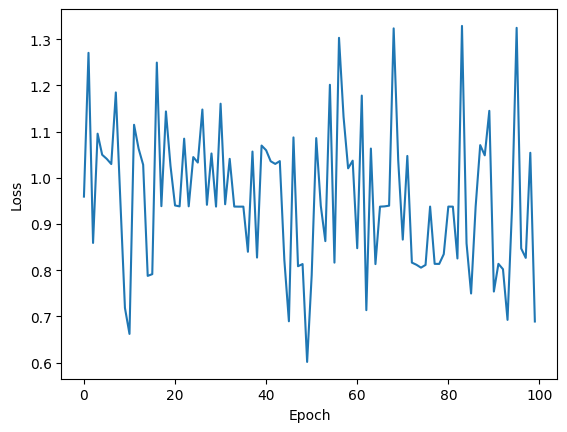

In [9]:
size = 3

model = ResNet(
    state_size=size**2,
    input_size=2,
    num_resBlocks=4,
    num_hidden=64
)

# Create a dataset of random states and their values (-1 if not in the solution, 1 if in the solution)
states = []
values = []

for _ in range(100):
    # Create a random matrix and a random permutation
    random_matrix = np.random.randint(1, 100, (size, size)).astype(np.float32)
    # Normalize the matrix line by line
    for i in range(size):
        total_value = random_matrix[i].sum()
        probs = [abs((value - total_value) ** 2) for value in random_matrix[i]]
        normalized_probs = [prob / sum(probs) for prob in probs]
        random_matrix[i] = np.round(normalized_probs, 2)

    random_permutation = np.random.permutation(size)
    solution = np.zeros((size, size))

    # Solve the problem with the Hungarian algorithm
    m = Munkres()
    indexes = m.compute(random_matrix.copy().tolist())
    valide_solution = np.zeros((size, size))
    for row, column in indexes:
        valide_solution[row][column] = 1


    state = np.stack([random_matrix, valide_solution], axis=0)
    state = torch.tensor(state, dtype=torch.float32)
    states.append(state)
    values.append(1)

    is_valid = True
    for k in range(np.random.randint(1, size + 1)):
        solution[k][random_permutation[k]] = 1
        if valide_solution[k][random_permutation[k]] != 1:
            is_valid = False

    state = np.stack([random_matrix, solution], axis=0)
    states.append(state)
    values.append(1 if is_valid else -1)

states = np.stack(states, axis=0)
values = np.array(values)

print(states[0], values[0])

# Create a dataset and a dataloader
dataset = torch.utils.data.TensorDataset(
    torch.tensor(states, dtype=torch.float32),
    torch.tensor(values, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_loss = np.inf
losses = []
for epoch in range(100):
    for states, values in dataloader:
        optimizer.zero_grad()
        outputs = model(states)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if loss.item() < best_loss:
        best_loss = loss.item()
        print(f"Epoch {epoch + 1}, loss: {loss.item()}")
    
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [11]:
import tensorflow as tf

model = ResNet(
    state_size=size**2,
    input_size=2,
    num_resBlocks=4,
    num_hidden=64
)

# Create a dataset and a dataloader
dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_states, dtype=torch.float32),
    torch.tensor(train_values, dtype=torch.float32)
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Tensorboard
writer = tf.summary.create_file_writer("logs")

best_loss = np.inf
losses = []

epoch = 0
while True:
    for states, values in dataloader:
        optimizer.zero_grad()
        outputs = model(states)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    with writer.as_default():
            tf.summary.scalar("loss", loss.item(), epoch)
    if loss.item() < best_loss:
        best_loss = loss.item()
        print(f"Epoch {epoch + 1}, loss: {loss.item()}")
        
    epoch += 1

c:\Users\hugoh\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 